Extracting datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST_data/t10k-labels-idx1-ubyte.gz


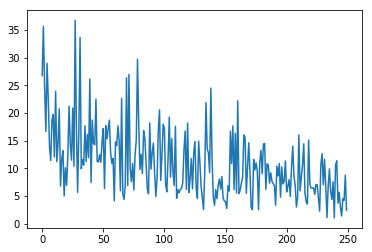

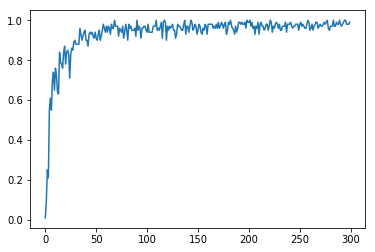

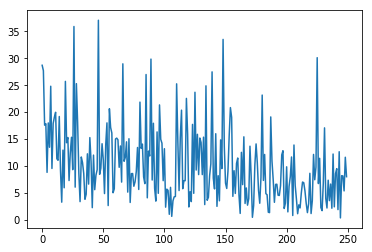

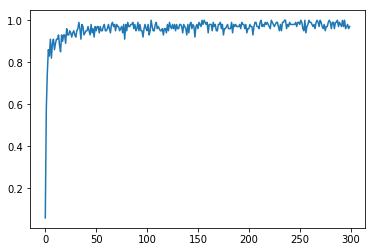

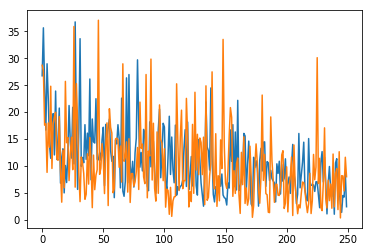

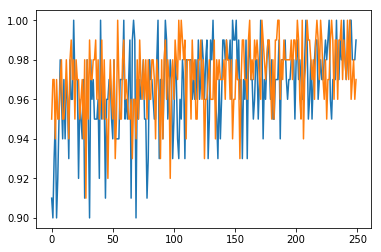

In [5]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("datasets/MNIST_data/", one_hot=True)


LEARNING_RATE = 0.05
ACTIVATION_FUNCTION = tf.nn.relu
INPUT_UNITS = 28*28
OUTPUT_UNITS = 10

FIRST_LAYER_KERNEL_SIZE = 5
SECOND_LAYER_KERNEL_SIZE = 3


def get_model_without_batch_norm():
    tf.reset_default_graph()
    is_training = tf.placeholder(tf.bool, name='is_training')
    x_placeholder = tf.placeholder(tf.float32, [None, INPUT_UNITS], name="x_placeholder")
    y_placeholder = tf.placeholder(tf.float32, [None, OUTPUT_UNITS], name="y_placeholder")
    x_image = tf.reshape(x_placeholder, [-1, 28, 28, 1])
    

    conv_layer1 = tf.layers.conv2d(x_image,
                                  32,
                                  (FIRST_LAYER_KERNEL_SIZE, FIRST_LAYER_KERNEL_SIZE),
                                  activation=tf.nn.relu,
                                  padding='same')
    pool_layer1 = tf.layers.max_pooling2d(conv_layer1,
                                         (2,2),
                                         (2,2),
                                         padding='same')


    conv_layer2 = tf.layers.conv2d(pool_layer1, 
                                   64, 
                                   (SECOND_LAYER_KERNEL_SIZE,SECOND_LAYER_KERNEL_SIZE), 
                                   activation = tf.nn.relu, 
                                   padding='same')
    pool_layer2 = tf.layers.max_pooling2d(conv_layer2,
                                          (2,2),
                                          (2,2),
                                          padding='SAME')
    
    flattened = tf.contrib.layers.flatten(pool_layer2)
    hidden_fully_connected_layer = tf.layers.dense(inputs=flattened, units=1024, activation=tf.nn.relu)
    y_conv = tf.layers.dense(inputs=hidden_fully_connected_layer, units=10, activation=None)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_placeholder,
                                                       logits=y_conv)
    loss = tf.reduce_sum(cross_entropy)
    train_step_cross_entropy = tf.train.AdamOptimizer().minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(y_placeholder,1), tf.argmax(y_conv,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return is_training, x_placeholder, y_placeholder, loss, train_step_cross_entropy, accuracy

    

def get_model_with_batch_norm():
    tf.reset_default_graph()
    is_training = tf.placeholder(tf.bool, name='is_training')
    x_placeholder = tf.placeholder(tf.float32, [None, INPUT_UNITS], name="x_placeholder")
    y_placeholder = tf.placeholder(tf.float32, [None, OUTPUT_UNITS], name="y_placeholder")
    x_image = tf.reshape(x_placeholder, [-1, 28, 28, 1])
    
    batch1 = tf.contrib.layers.batch_norm(x_image, is_training=is_training)
    conv_layer1 = tf.layers.conv2d(batch1,
                                  32,
                                  (FIRST_LAYER_KERNEL_SIZE, FIRST_LAYER_KERNEL_SIZE),
                                  activation=tf.nn.relu,
                                  padding='same')
    pool_layer1 = tf.layers.max_pooling2d(conv_layer1,
                                         (2,2),
                                         (2,2),
                                         padding='same')

    batch2 = tf.contrib.layers.batch_norm(pool_layer1, is_training=is_training)
    conv_layer2 = tf.layers.conv2d(pool_layer1, 
                                   64, 
                                   (SECOND_LAYER_KERNEL_SIZE,SECOND_LAYER_KERNEL_SIZE), 
                                   activation = tf.nn.relu, 
                                   padding='same')
    pool_layer2 = tf.layers.max_pooling2d(conv_layer2,
                                          (2,2),
                                          (2,2),
                                          padding='SAME')
    
    flattened = tf.contrib.layers.flatten(pool_layer2)
    batch3 = tf.contrib.layers.batch_norm(flattened, is_training=is_training)
    hidden_fully_connected_layer = tf.layers.dense(inputs=batch3, units=1024, activation=tf.nn.relu)
    batch4 = tf.contrib.layers.batch_norm(hidden_fully_connected_layer, is_training=is_training)
    y_conv = tf.layers.dense(inputs=batch4, units=10, activation=None)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_placeholder,
                                                       logits=y_conv)
    loss = tf.reduce_sum(cross_entropy)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_step_cross_entropy = tf.train.AdamOptimizer().minimize(loss)
    
    correct_prediction = tf.equal(tf.argmax(y_placeholder,1), tf.argmax(y_conv,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return is_training, x_placeholder, y_placeholder, loss, train_step_cross_entropy, accuracy

is_tr, inplaceholder, outplaceholder, loss_tensor, train_op, acc = get_model_without_batch_norm()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = list()
accuracies = list()
ITERATIONS = 300
BATCH_SIZE = 100
for iteration in range(ITERATIONS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    _, l,a = sess.run([train_op, loss_tensor, acc], feed_dict={inplaceholder: batch[0], outplaceholder: batch[1]})
    losses.append(l)
    accuracies.append(a)
%matplotlib inline
import matplotlib.pyplot as plt
start_plt_losses = 50
plt.plot(losses[start_plt_losses:])
plt.show()
plt.plot(accuracies)
plt.show()

ac_without_batch = accuracies
loss_without_batch = losses


is_tr, inplaceholder, outplaceholder, loss_tensor, train_op, acc = get_model_with_batch_norm()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

losses = list()
accuracies = list()
for iteration in range(ITERATIONS):
    batch = mnist.train.next_batch(BATCH_SIZE)
    _, l,a = sess.run([train_op, loss_tensor, acc], feed_dict={inplaceholder: batch[0], outplaceholder: batch[1],
                                                              is_tr: True})
    losses.append(l)
    accuracies.append(a)
%matplotlib inline
import matplotlib.pyplot as plt
start_plt_losses = 50
plt.plot(losses[start_plt_losses:])
plt.show()
plt.plot(accuracies)
plt.show()


plt.plot(loss_without_batch[start_plt_losses:])
plt.plot(losses[start_plt_losses:])
plt.show()
plt.plot(ac_without_batch[start_plt_losses:])
plt.plot(accuracies[start_plt_losses:])
plt.show()

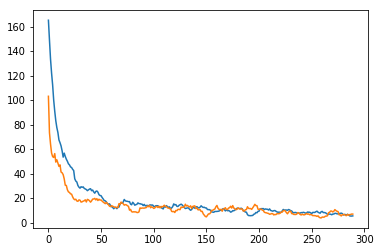

In [13]:
import numpy as np
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):-N]
a = runningMeanFast(loss_without_batch, 10)
b = runningMeanFast(losses, 10)
plt.plot(a)
plt.plot(b)
plt.show()

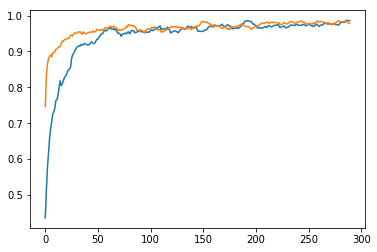

In [14]:
a = runningMeanFast(ac_without_batch, 10)
b = runningMeanFast(accuracies, 10)
plt.plot(a)
plt.plot(b)
plt.show()